In [74]:
import pandas as pd
import os
import numpy as np
from queue import Queue
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.covariance import EllipticEnvelope
import random
import math
import time
from math import sin,cos
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

In [3]:
root = '/Users/guoqiushi/Documents/thesis/indoor_final/'

In [6]:
class ml_fileObject:

    def __init__(self, root, index):
        self.root = root
        self.index = index
        self.path = os.path.join(root, str(index))
        for files in os.listdir(self.path):
            if files.startswith('IMU'):
                self.imu_path = os.path.join(self.path, files)
            elif files.startswith('Mag'):
                self.mag_path = os.path.join(self.path, files)
            elif files.startswith('ultra'):
                self.ultra_path = os.path.join(self.path, files)
        self.height_dict = {
            '1': 0.736,
            '2': 0.782,
            '3': 0.827,
            '4': 0.877,
            '5': 0.936,
            '6': 0.981,
            '7': 1.043,
            '8': 1.102
        }

    def get_ultra(self):
        Dataframe = pd.read_csv(self.ultra_path, sep=" ",
                                names=["ID", "P_x", "P_y", "P_z", "unknow", "unknow_1", "Time_Stamp"])
        Dataframe = Dataframe.drop(["ID", "unknow", "unknow_1"], axis=1)
        rows, columns = Dataframe.shape
        serial_num = np.arange(0, rows, 1).tolist()
        serial_num_inte = np.arange(0, rows, 0.1).tolist()
        Px_inte = np.interp(serial_num_inte, serial_num, Dataframe["P_x"])
        Py_inte = np.interp(serial_num_inte, serial_num, Dataframe["P_y"])
        Pz_inte = np.interp(serial_num_inte, serial_num, Dataframe["P_z"])
        Pt_inte = np.interp(serial_num_inte, serial_num, Dataframe["Time_Stamp"])
        Dataframe_inte = pd.DataFrame(columns=["Serial_Num", 'P_X', 'P_Y', 'P_Z', "Time_Stamp"])
        Dataframe_inte["Serial_Num"] = np.arange(0, len(serial_num_inte), 1).tolist()
        Dataframe_inte["P_X"] = Px_inte
        Dataframe_inte["P_Y"] = Py_inte
        Dataframe_inte['P_Z'] = self.height_dict[str(self.index)]
        # Dataframe_inte["P_Z"] = Pz_inte
        Dataframe_inte["Time_Stamp"] = Pt_inte
        return Dataframe_inte

    def get_mag(self):
        df_tem = pd.read_csv(self.mag_path, sep=" ", names=["Serial_Num", "R_x", "R_y", "R_z", "Time_Stamp"],
                             index_col="Serial_Num")
        df_tem["Magnitude"] = np.sqrt(
            np.power(df_tem["R_x"], 2) + np.power(df_tem["R_y"], 2) + np.power(df_tem["R_z"], 2))
        return df_tem

    def get_imu(self):
        df_tem = pd.read_csv(self.imu_path, sep=" ",
                             names=['a_x', 'a_y', 'a_z', 'G_x', 'G_y', 'G_z', 'M_x', 'M_y', 'M_z', 'alpha', 'beta',
                                    'gama', 'mill', 'Time_Stamp', 'index'],
                             index_col="index")
        return df_tem

    def get_IMU_info(self, time_mag, df_imu):
        time_imu = df_imu['Time_Stamp'].to_numpy()
        sub_array = abs(time_imu - time_mag)
        index = np.argmin(sub_array)
        alpha, beta, gama = df_imu.iloc[index, 9], df_imu.iloc[index, 10], df_imu.iloc[index, 11]
        a_x, a_y, a_z = df_imu.iloc[index, 0], df_imu.iloc[index, 1], df_imu.iloc[index, 2]
        return a_x, a_y, a_z, alpha, beta, gama

    def get_position(self, time_mag, df_ultra):
        time_ultra = df_ultra['Time_Stamp'].to_numpy()
        sub_array = abs(time_ultra - time_mag)
        index = np.argmin(sub_array)
        p_x, p_y, p_z = df_ultra.iloc[index, 1], df_ultra.iloc[index, 2], df_ultra.iloc[index, 3]
        # print(p_x,p_y,p_z)
        return p_x, p_y, p_z

    def merge_all(self):
        df_mag = self.get_mag()
        df_ultra = self.get_ultra()
        df_imu = self.get_imu()
        position = []
        imu_data = []
        for i in range(df_mag.shape[0]):
            position.append(self.get_position(df_mag.iloc[i, 3], df_ultra))
            imu_data.append(self.get_IMU_info(df_mag.iloc[i, 3], df_imu))
        position_array = np.array(position)
        imu_data_array = np.array(imu_data)
        df_mag['p_x'] = position_array[:, 0]
        df_mag['p_y'] = position_array[:, 1]
        df_mag['p_z'] = position_array[:, 2]
        df_mag['d_t1'] = np.sqrt(
            np.power(position_array[:, 0] - 1.90, 2) + np.power(position_array[:, 1] - 0.17, 2) + np.power(
                position_array[:, 2] - 1.24, 2))
        df_mag['d_t2'] = np.sqrt(
            np.power(position_array[:, 0] - 5.00, 2) + np.power(position_array[:, 1] - 0.33, 2) + np.power(
                position_array[:, 2] - 1.24, 2))
        df_mag['d_t3'] = np.sqrt(
            np.power(position_array[:, 0] - 3.23, 2) + np.power(position_array[:, 1] + 2.94, 2) + np.power(
                position_array[:, 2] - 1.24, 2))
        df_mag['a_x'] = imu_data_array[:, 0]
        df_mag['a_y'] = imu_data_array[:, 1]
        df_mag['a_z'] = imu_data_array[:, 2]
        df_mag['alpha'] = imu_data_array[:, 3]
        df_mag['beta'] = imu_data_array[:, 4]
        df_mag['gama'] = imu_data_array[:, 5]
        return df_mag

    def get_T_index(self, noise_threshould):
        df_mag_merge = self.merge_all()
        mag_array = np.array(df_mag_merge['Magnitude'].tolist())
        mag_index = []
        for rows in range(10, df_mag_merge.shape[0] - 100):
            if np.sum(mag_array[rows - 1:rows + 4]) < np.sum(mag_array[rows:rows + 5]) and np.sum(
                    mag_array[rows + 1:rows + 6]) < np.sum(mag_array[rows:rows + 5]) and np.min(
                mag_array[rows:rows + 5]) > noise_threshould:  #### outdoor: 6800000
                mag_index.append(rows)
        T1_start = []
        T2_start = []
        T3_start = []

        for index in range(len(mag_index) - 3):
            if 7 < mag_index[index + 2] - mag_index[index + 1] < 11 and 7 < mag_index[index + 1] - mag_index[
                index] < 11:
                T1_start.append(mag_index[index])


            elif 10 < mag_index[index + 2] - mag_index[index + 1] < 14 and 7 < mag_index[index + 1] - mag_index[
                index] < 11:
                T2_start.append(mag_index[index])

            elif 7 < mag_index[index + 2] - mag_index[index + 1] < 11 and 10 < mag_index[index + 1] - mag_index[
                index] < 14:
                T3_start.append(mag_index[index])

        return T1_start, T2_start, T3_start

    def get_ml_features(self):
        df_mag_merge = self.merge_all()
        t1,t2,t3 = self.get_T_index(8000000)
        period_start = []
        for item in t1:
            period_start.append(item)
        for item in t2:
            period_start.append(item - 40)
        for item in t3:
            period_start.append(item - 80)
        T1_start = []
        sorted_begin_list = sorted(period_start)
        for i in range(1, len(period_start)):
            if sorted_begin_list[i] - sorted_begin_list[i - 1] > 2:
                T1_start.append(sorted_begin_list[i])
        feature_list = []
        feature_index = []
        for item in T1_start:
            feature_list.append(
                (item, item + 9, item + 18, item + 40, item + 49, item + 60, item + 80, item + 92, item + 102))
            feature_index.extend(
                (item, item + 9, item + 18, item + 40, item + 49, item + 60, item + 80, item + 92, item + 102))
        x_feature = []
        y_feature = []

        for item in feature_list:
            x_feature.append([
                max(df_mag_merge.iloc[item[0]:item[0] + 5, 4]),
                max(df_mag_merge.iloc[item[1]:item[1] + 5, 4]),
                max(df_mag_merge.iloc[item[2]:item[2] + 5, 4]),
                max(df_mag_merge.iloc[item[3]:item[3] + 5, 4]),
                max(df_mag_merge.iloc[item[4]:item[4] + 5, 4]),
                max(df_mag_merge.iloc[item[5]:item[5] + 5, 4]),
                max(df_mag_merge.iloc[item[6]:item[6] + 5, 4]),
                max(df_mag_merge.iloc[item[7]:item[7] + 5, 4]),
                max(df_mag_merge.iloc[item[8]:item[8] + 5, 4]),

            ])
            y_feature.append(
                [df_mag_merge.iloc[item[0], 5], df_mag_merge.iloc[item[0], 6], df_mag_merge.iloc[item[0], 7]])
        return x_feature,y_feature


In [7]:
file_1  = ml_fileObject(root,1)
file_2  = ml_fileObject(root,2)
file_3  = ml_fileObject(root,3)
file_4  = ml_fileObject(root,4)
file_5  = ml_fileObject(root,5)
file_6  = ml_fileObject(root,6)
file_7  = ml_fileObject(root,7)
file_8  = ml_fileObject(root,8)

In [8]:
x_feature_1,y_feature_1 = file_1.get_ml_features()
x_feature_2,y_feature_2 = file_2.get_ml_features()
x_feature_3,y_feature_3 = file_3.get_ml_features()
x_feature_4,y_feature_4 = file_4.get_ml_features()
x_feature_5,y_feature_5 = file_5.get_ml_features()
x_feature_6,y_feature_6 = file_6.get_ml_features()
x_feature_7,y_feature_7 = file_7.get_ml_features()
x_feature_8,y_feature_8 = file_8.get_ml_features()

In [9]:
df_1 = file_1.merge_all()

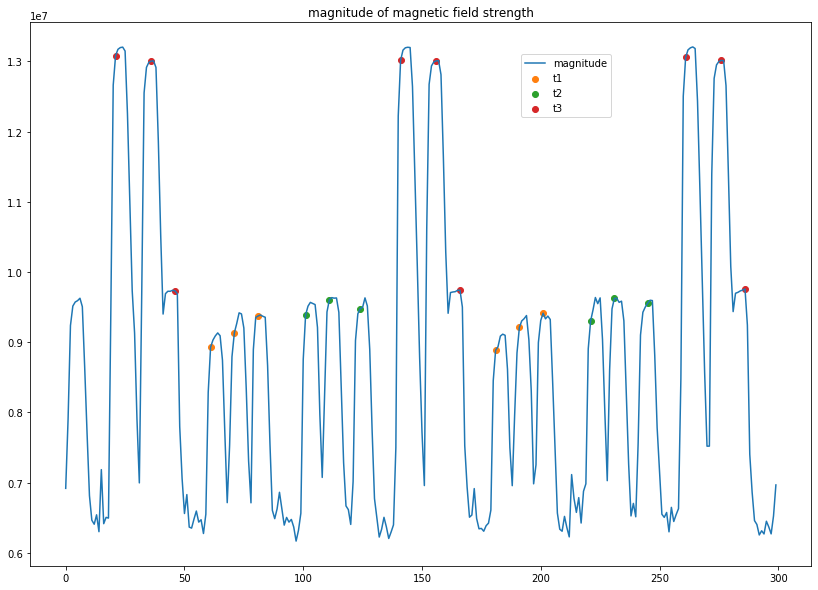

In [69]:
plt.figure(figsize=(14,10))
plt.plot(df_1['Magnitude'][:300],c='C0',label='magnitude')
plt.scatter(t1,mag_t1,c='C1',label='t1')
plt.scatter(t2,mag_t2,c='C2',label='t2')
plt.scatter(t3,mag_t3,c='C3',label='t3')
plt.legend(loc='upper right',bbox_to_anchor=(0.75,0.95))
plt.title('magnitude of magnetic field strength')
plt.savefig('/Users/guoqiushi/Documents/magnitude.png')

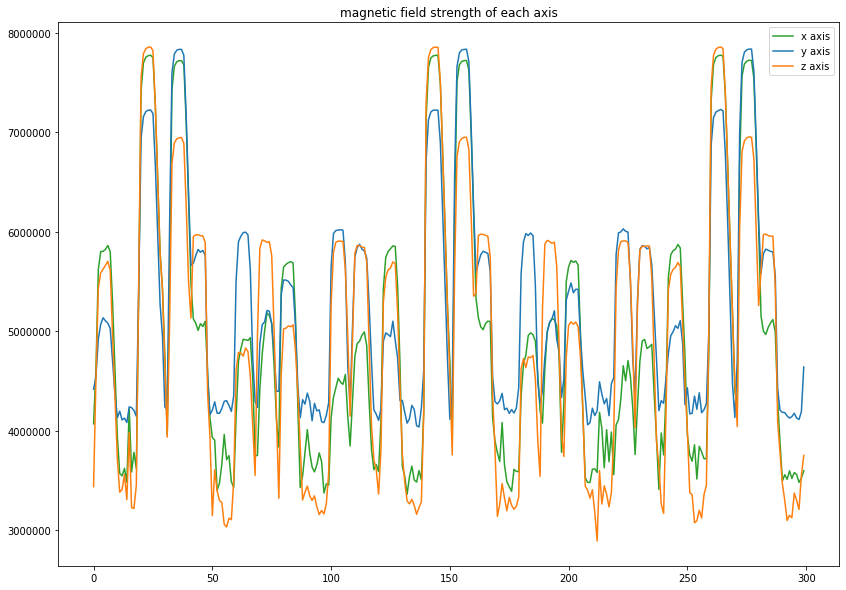

In [31]:
plt.figure(figsize=(14,10))
plt.title('magnetic field strength of each axis')
plt.plot(df_1['R_x'][:300],c='C2',label='x axis')
plt.plot(df_1['R_y'][:300],c='C0',label='y axis')
plt.plot(df_1['R_z'][:300],c='C1',label='z axis')
plt.legend(loc='upper right')
plt.savefig('/Users/guoqiushi/Documents/mag_axis.png')

In [19]:
df_1.head()

,R_x,R_y,R_z,Time_Stamp,Magnitude,p_x,p_y,p_z,d_t1,d_t2,d_t3,a_x,a_y,a_z,alpha,beta,gama
Serial_Num,,,,,,,,,,,,,,,,,
0,4067828,4416114,3437311,1.577189e+09,6.918410e+06,3.5275,-2.3140,0.736,3.012147,3.068063,0.856970,9.73,-0.36,-0.25,80.75,87.94,178.44
1,4621398,4541348,4527130,1.577189e+09,7.904180e+06,3.5274,-2.3138,0.736,3.011928,3.067938,0.857082,9.73,-0.36,-0.25,80.75,87.94,178.44
2,5619091,4922593,5433125,1.577189e+09,9.237151e+06,3.5273,-2.3136,0.736,3.011709,3.067814,0.857193,9.73,-0.36,-0.25,80.75,87.94,178.44
3,5799406,5067350,5587005,1.577189e+09,9.514503e+06,3.5273,-2.3136,0.736,3.011709,3.067814,0.857193,9.68,-0.32,-0.18,80.75,87.94,178.44
4,5801290,5134238,5621855,1.577189e+09,9.571866e+06,3.5273,-2.3136,0.736,3.011709,3.067814,0.857193,9.68,-0.32,-0.18,80.75,87.94,178.44


In [54]:
t1,t2,t3 = file_1.get_T_index(8000000)

In [62]:
t1 = [61,71,81,181,191,201]
mag_t1 = [get_mag(df_1,x) for x in t1]
t2 = [101,111,124,221,231,245]
mag_t2 = [get_mag(df_1,x) for x in t2]
t3 = [21,36,46,141,156,166,261,276,286]
mag_t3 = [get_mag(df_1,x) for x in t3]

In [49]:
def get_mag(df,index):
    return df.iloc[index,4]

In [75]:
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,max_depth=20,random_state=0))


In [107]:
x_train = x_feature_1+x_feature_2+x_feature_3+x_feature_5+x_feature_6+x_feature_7+x_feature_8
y_train = y_feature_1+y_feature_2+y_feature_3+y_feature_5+y_feature_6+y_feature_7+y_feature_8

In [108]:
x_test = x_feature_4
y_test = y_feature_4

In [109]:
x_scaler = preprocessing.StandardScaler().fit(x_train)
y_scaler = preprocessing.StandardScaler().fit(y_train)

In [110]:
x_train = x_scaler.transform(x_train)
y_train = y_scaler.transform(y_train)

In [111]:
x_test = x_scaler.transform(x_test)

In [92]:
model.fit(x_train,y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
           n_jobs=None)

In [173]:
result_4 = y_scaler.inverse_transform(model.predict(x_test)).tolist()

In [152]:
outlier_detect = IsolationForest(behaviour='new', max_samples=10,random_state=1, contamination='auto',n_estimators=6)
outlier_detect.fit(test_10)

IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
        max_features=1.0, max_samples=10, n_estimators=6, n_jobs=None,
        random_state=1, verbose=0)

In [153]:
outlier_detect.predict(test_10)

array([ 1,  1,  1,  1,  1,  1,  1,  1, -1, -1])

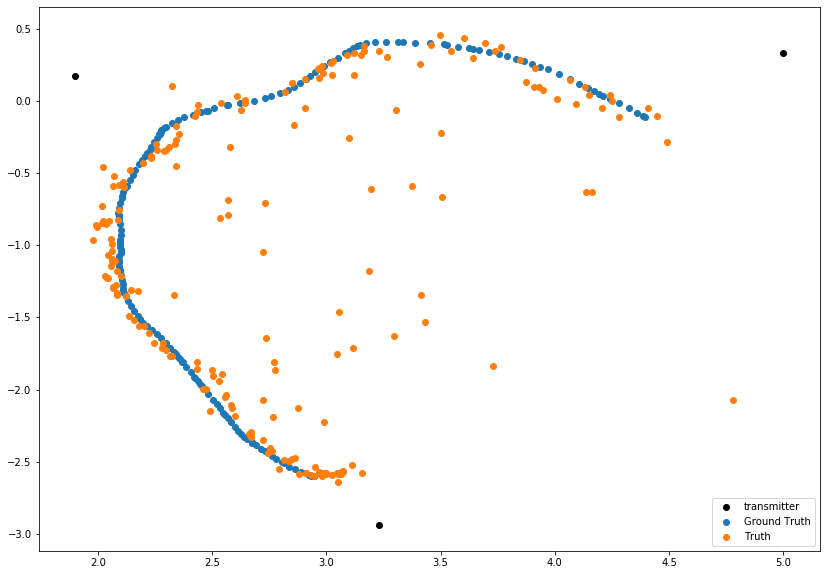

In [314]:
y_test = np.array(y_test)
result_4 = np.array(result_4)
filter_list = np.array(filter_list)
plt.figure(figsize=(14,10))
plt.scatter([1.90,5.00,3.23],[0.17,0.33,-2.94],c='black',label='transmitter')
plt.scatter(y_test[:200,0],y_test[:200,1],c='C0',label='Ground Truth')
plt.scatter(result_4[:200,0],result_4[:200,1],c='C1',label='Truth')
#plt.scatter(period_prediction[:,0],period_prediction[:,1],c='C1')
plt.legend(loc='lower right')
plt.savefig('./figure/sequence_no_filter.png')
plt.show()

In [277]:
def period_test(index):
    outlier_detect = IsolationForest(max_samples=10,contamination=0.3,behaviour='new',n_estimators=10)
    outlier_detect.fit(result_4[index*10:(index+1)*10])
    outlier_index = outlier_detect.predict(result_4[index*10:(index+1)*10])
    
    single_prediction = result_4[index*10:(index+1)*10]
    result = [single_prediction[i] for i,x in enumerate(outlier_index)if x!=-1]
    
    return result

In [301]:
test = []
for i in range(20):
    test.extend(period_test(i))

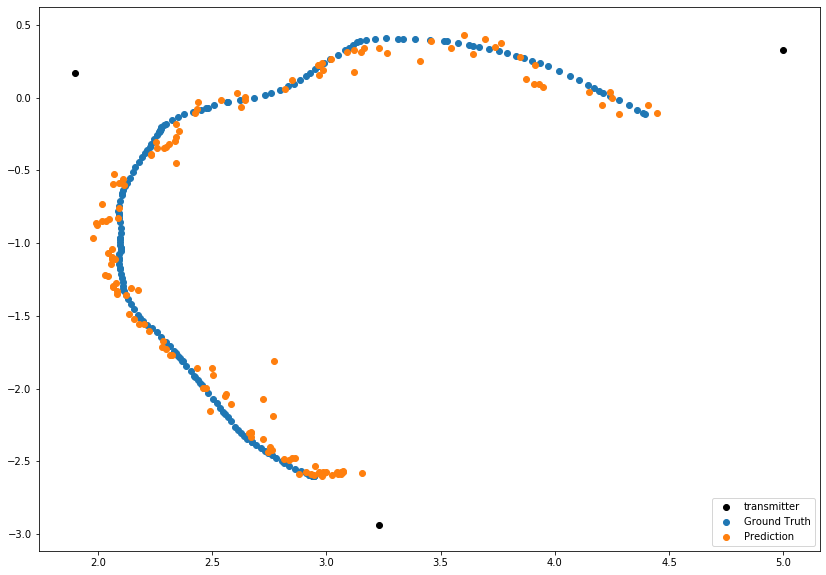

In [308]:
test = np.array(test)
plt.figure(figsize=(14,10))
plt.scatter([1.90,5.00,3.23],[0.17,0.33,-2.94],c='black',label='transmitter')
plt.scatter(y_test[:200,0],y_test[:200,1],c='C0',label='Ground Truth')
plt.scatter(test[:,0],test[:,1],c='C1',label='Prediction')
plt.legend(loc='lower right')
plt.savefig('./figure/sequence_filter.png')
plt.show()